In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Data Generation
def random_matrix():
    return np.random.randn(100, 200)

def random_sparse_vector(sparsity=0.1):
    x_true = np.zeros(200)
    non_zero_indices = np.random.choice(200, int(200*sparsity), replace=False)
    x_true[non_zero_indices] = np.random.randn(int(200*sparsity))
    return x_true

#  normalize, target average value in magnitude of Ax is 1, (sum of all elements in Ax is 100)
def normalize(A, x_true, norm_factor=0.01):
    return x_true / (norm_factor*np.linalg.norm(A @ x_true, ord=1))

# add noise to the data
def add_noise(b, noise_level):
    eta = noise_level * np.random.randn(len(b))
    return b + eta

def calc_f_score(x_true, x_star):
    
    tp = np.sum((x_true != 0) & (x_star != 0))
    fp = np.sum((x_true == 0) & (x_star != 0))
    fn = np.sum((x_true != 0) & (x_star == 0))
    
    fscore = 2 * tp / (2 * tp + fp + fn) if tp + fp + fn > 0 else 0
    
    return fscore

def soft_thresholding(x_hat, threshold):
    return np.sign(x_hat) * np.maximum(np.abs(x_hat) - threshold, 0)

# ISTA Implementation
def ista(A, b, lambd, x0=None, max_iter=1000, tol=1e-6):
    m, n = A.shape
    c = np.linalg.norm(A.T @ A, ord=2)
    
    if x0 is None:
        x_hat = np.zeros(n)
    else:
        x_hat = x0.copy()

    obj_values = []
    subgrad_norms = []

    for _ in range(max_iter):
        grad = A.T @ (A @ x_hat - b)
        x_new = soft_thresholding(x_hat - grad / c, lambd / c)
        
        obj_value = np.linalg.norm(A @ x_new - b) ** 2 + lambd * np.linalg.norm(x_new, ord=1)
        obj_values.append(obj_value)
        
        subgrad_norm = np.linalg.norm(x_new - x_hat)
        subgrad_norms.append(subgrad_norm)

        if subgrad_norm < tol:
            break
        x_hat = x_new

    return x_hat, obj_values, subgrad_norms

In [68]:
# Data Generation
A = random_matrix()
x_true = random_sparse_vector(sparsity=0.1)

# Normalize x_true
x_true = normalize(A, x_true)

#  verification of normalization
mean_abs_Ax = np.mean(np.abs(A @ x_true))
print(f"Mean absolute value of A x after normalization: {mean_abs_Ax}")

# Add noise to the data
b = add_noise(A @ x_true, noise_level=0.01)

# Lambda Selection and Metrics
lambda_0 = 0.1 * np.linalg.norm(A.T @ b, ord=np.inf)

lambda_max = 100 * lambda_0
lambda_min = lambda_0 / 100

lambda_values = np.logspace(np.log10(lambda_max), np.log10(lambda_min), 50)
mse_values = []
fscore_values = []

x_prev = None

for lambd in lambda_values:
    
    x_star, _, _ = ista(A, b, lambd, x0=x_prev)
    x_prev = x_star.copy()
    
    mse = np.mean((x_true - x_star) ** 2)
    fscore = calc_f_score(x_true, x_star)
    
    mse_values.append(mse)
    fscore_values.append(fscore)

# example of the result
x_star_debug, obj_values_debug, subgrad_norms_debug = ista(A, b, lambda_values[np.argmin(mse_values)])


Mean absolute value of A x after normalization: 1.0


In [69]:
# #best lambda
lambda_best_fscore = lambda_values[np.argmax(fscore_values)]
lambda_best_mse = lambda_values[np.argmin(mse_values)]
print("best fscore: ", np.max(fscore_values))
print("Best lambda for F-score: ", lambda_best_fscore)
print("Best lambda for MSE: ", lambda_best_mse)

#mse on the fscore best lambda
x_star_fscore, _, _ = ista(A, b, lambda_best_fscore)

np.mean((x_true - x_star_fscore) ** 2)
print("MSE on the F-score best lambda: ", np.mean((x_true - x_star_fscore) ** 2))
print("best mse: ", np.min(mse_values))
# x_star_mse, _, _ = ista(A, b, lambda_best_mse)
# x_star_fscore, _, _ = ista(A, b, lambda_best_fscore)

# # make sure that values under 0.01 are considered as zero
# x_star_mse[np.abs(x_star_mse) < 0.01] = 0

# # print non-zero elements indices in x_star_mse and x_true
# print("x_star_mse", np.where(x_star_mse != 0))
# print("x_true", np.where(x_true != 0))

# # how many non-zero elements in x_star_mse are also non-zero in x_true
# print("tp" , np.sum((x_true != 0) & (x_star_mse != 0)))

# # how many non-zero elements in x_star_mse are zero in x_true
# print("fp" , np.sum((x_true == 0) & (x_star_mse != 0)))      
# # how many zero elements in x_star_mse are non-zero in x_true
# print("fn" , np.sum((x_true != 0) & (x_star_mse == 0)))
      
# # how many zero elements in x_star_mse are also zero in x_true
# print("tn" , np.sum((x_true == 0) & (x_star_mse == 0)))

print(obj_values_debug)


best fscore:  0.7843137254901961
Best lambda for F-score:  0.41026859382859754
Best lambda for MSE:  0.07557434560495589
MSE on the F-score best lambda:  3.948455000483633e-06
best mse:  5.285407998900146e-07
[49.15905439311348, 23.33521625875968, 13.32476605868968, 8.591551791481704, 6.038270760855216, 4.5224442577294885, 3.5534224775108125, 2.898025044401515, 2.434341403157279, 2.0931038419513506, 1.8349204845536997, 1.6346665548448038, 1.475604192801598, 1.3472107630685253, 1.242301496085275, 1.155585110312882, 1.08289349219274, 1.0214183442884555, 0.9690439416391388, 0.9241783803341123, 0.8856814841882323, 0.8526624394542042, 0.8242189320213086, 0.799466728871579, 0.777806692587011, 0.7587909839067573, 0.7420481598537227, 0.7272669408624313, 0.7141844729044982, 0.7025774822748739, 0.6922851197603961, 0.6831763172358826, 0.6750459579545887, 0.6677684031857181, 0.6612435048447929, 0.6553893153570757, 0.650162585817343, 0.64548283930368, 0.6412529586847835, 0.6374476304044109, 0.63403

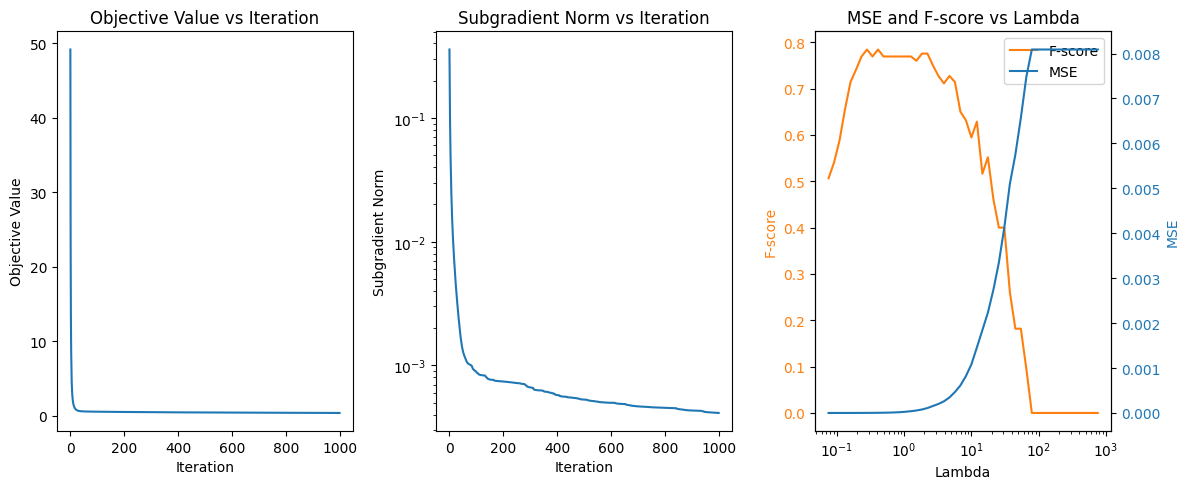

In [70]:
# Visualizations
plt.figure(figsize=(12, 5))

# Objective Values
plt.subplot(1, 3, 1)
plt.plot(obj_values_debug)
plt.xlabel("Iteration")
plt.ylabel("Objective Value")
plt.title("Objective Value vs Iteration")

# Subgradient Norms
plt.subplot(1, 3, 2)
plt.semilogy(subgrad_norms_debug)
plt.xlabel("Iteration")
plt.ylabel("Subgradient Norm")
plt.title("Subgradient Norm vs Iteration")

# MSE and F-score with dual axes
ax3 = plt.subplot(1, 3, 3)
ax3.set_xlabel('Lambda')
ax3.set_ylabel('F-score', color='tab:orange')
ax3.plot(lambda_values, fscore_values, color='tab:orange', label='F-score')
ax3.tick_params(axis='y', labelcolor='tab:orange')
ax3.set_xscale('log')

# Create secondary y-axis for MSE
ax3_twin = ax3.twinx()
ax3_twin.set_ylabel('MSE', color='tab:blue')
ax3_twin.plot(lambda_values, mse_values, color='tab:blue', label='MSE')
ax3_twin.tick_params(axis='y', labelcolor='tab:blue')

# Add combined legend for the third subplot
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Set the title on the ax3 axes
ax3.set_title("MSE and F-score vs Lambda")

# Adjust the layout
plt.tight_layout()
plt.show()